# Information Pursuit: A Wikispeedia Analysis

This notebook developes an in-depth analysis of the `Wikispeedia` dataset. The goal is to identify the characteristics of human navigation paths, and use this knowledge to produce useful insights on common human strategies.

This study requires advanced inspection of the Wikispeedia network of pages, and the results collected from multiple thousand games.

This notebook is divided into four main parts:
1. Why analyze commonly used strategies
1. Wikispeedia network analysis
2. Strategies analysis
3. Strategies evaluation

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Why analyze commonly used strategies

### Loading the data

Before stepping into the analysis, we first describe briefly the data at hand. This also allows us to show a few transformations that have been done to ease data manipulation.

Load and transform some data to make it easy to use

In [125]:
from src.utils.data import load_graph_data
from src.utils import describe_dict


graph_data = load_graph_data()
describe_dict(graph_data)

Keyword                       | Type (shape)          
------------------------------------------------------
paths_finished                  DataFrame (51318, 9)  
articles                        DataFrame (4604, 1)   
links                           DataFrame (119882, 2) 
shortest-path-distance-matrix   DataFrame (319476, 1) 
categories                      DataFrame (5204, 2)   
paths_unfinished                DataFrame (24875, 9)  
graph                           DiGraph (4604, 119944)
target_median_duration          DataFrame (3997, 3)   
top_200_hubs                    List (200)            


### Why analysing human behaviors

In [126]:
from src.utils.analyzers.human_behavior_analyzer import game_stats_comparison_df

# Show differences between paths and shortest paths
paths_info = game_stats_comparison_df(graph_data)
paths_info

path_length                             \
                                          count       mean       std   min   
source       target                                                          
10th_century 11th_century                   3.0   2.000000  0.000000   2.0   
             Country                        1.0   3.000000       NaN   3.0   
14th_century African_slave_trade            3.0   7.333333  2.081666   5.0   
             Elizabeth_I_of_England         4.0   7.500000  5.744563   4.0   
             Fire                           1.0   4.000000       NaN   4.0   
...                                         ...        ...       ...   ...   
Zirconium    Hebrew_calendar                1.0   5.000000       NaN   5.0   
             Magna_Carta                    1.0   4.000000       NaN   4.0   
             Robinson_Crusoe                1.0  10.000000       NaN  10.0   
             United_Kingdom                 1.0   4.000000       NaN   4.0   
             Ununbium                       1.0   3.000000       NaN   3.0   

                                                            shortest_distance  
                                      25%   50%   75%   max                    
source       target                                                            
10th_century 11th_century             2.0   2.0   2.0   2.0               1.0  
             Country                  3.0   3.0   3.0   3.0               2.0  
14th_century African_slave_trade      6.5   8.0   8.5   9.0               3.0  
             Elizabeth_I_of_England   4.0   5.0   8.5  16.0               2.0  
             Fire                     4.0   4.0   4.0   4.0               3.0  
...                                   ...   ...   ...   ...               ...  
Zirconium    Hebrew_calendar          5.0   5.0   5.0   5.0               3.0  
             Magna_Carta              4.0   4.0   4.0   4.0               3.0  
             Robinson_Crusoe         10.0  10.0  10.0  10.0               4.0  
             United_Kingdom           4.0   4.0   4.0   4.0               2.0  
             Ununbium                 3.0   3.0   3.0   3.0               2.0  

[5585 rows x 9 columns]

In [127]:
from src.utils.analyzers.human_behavior_analyzer import game_stats_simple_join

# Show differences between paths and shortest paths
stats = game_stats_simple_join(graph_data)
stats

optimal_path_length                      source               target  \
49                     3.0                14th_century  African_slave_trade   
50                     3.0                14th_century  African_slave_trade   
51                     3.0                14th_century  African_slave_trade   
57                     2.0                14th_century               Greece   
59                     3.0                14th_century      John_F._Kennedy   
...                    ...                         ...                  ...   
41027                  3.0  Star_Trek__Deep_Space_Nine            Full_moon   
41021                  3.0  Star_Trek__Deep_Space_Nine          Agnosticism   
41024                  3.0  Star_Trek__Deep_Space_Nine              Eldfell   
27204                  3.0           Liberal_democracy               Osmium   
27203                  3.0           Liberal_democracy     Canute_the_Great   

       path_length  
49             5.0  
50             8.0  
51             9.0  
57             4.0  
59             7.0  
...            ...  
41027          4.0  
41021          6.0  
41024          6.0  
27204          7.0  
27203          5.0  

[12455 rows x 4 columns]

In [128]:
from src.utils.analyzers.human_behavior_analyzer import game_stats_survival_plot
game_stats_survival_plot(stats)

In [129]:
from scipy import stats

print(stats.pearsonr(paths_info[("path_length", "mean")], paths_info["shortest_distance"]))
# There is a positive correlation coefficient between the average path length and the shortest distance.
# We get a p-value close to 0 which indicate that the coefficient is statistically significant.

PearsonRResult(statistic=0.48137486194062207, pvalue=5.93e-322)


# Wikispeedia network analysis

We will start our work by analyzing the Wikispeedia graph.

For this, we create a graph of the wikispeedia game where:
- Each node in the graph represents an article
- A directed edge (u, v) exists if there is a hyperlink from article u to article v.
- The weight of an edge (u, v) represents the number of times users navigated from article u to article v.


We want to analyze how often users click on the provided hyperlinks

{0: 0.5272043620356166, 1: 0.17350596945241112, 2: 0.08539818582004936, 3: 0.051057160008003734, 4: 0.032865337157340094}


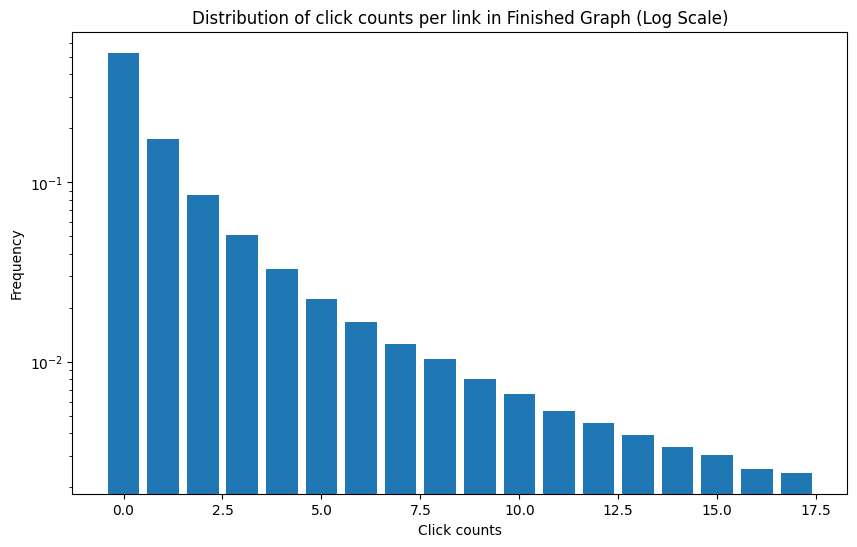

In [130]:
from matplotlib import pyplot as plt

# Extract edge weights
weights = [data["weight"] for _, _, data in graph_data["graph"].edges(data=True)]
num_edges = len(weights)
frequencies = {w: weights.count(w) / num_edges for w in set(weights)}

# Cut off the tail for better visualization
cutoff = 0.0023
filtered_frequencies = {k: v for k, v in frequencies.items() if v >= cutoff}

# Plot filtered_frequencies with log scale
plt.figure(figsize=(10, 6))
plt.bar(filtered_frequencies.keys(), filtered_frequencies.values())
plt.xlabel("Click counts")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of click counts per link in Finished Graph (Log Scale)")

# Print only the first 5 frequencies
print(dict(list(frequencies.items())[:5]))

As we can see in the above graph, 52% of the hyperlinks were never clicked by any user, 17% of the hyperlinks were clicked only once and 8% of the hyperlinks were clicked twice. Let's take a closer look at that.

Below are the 20 most clicked hyperlinks by any user

In [131]:
import pandas as pd

edges = [(u, v, data["weight"]) for u, v, data in graph_data["graph"].edges.data()]
edges = pd.DataFrame(edges, columns=["from", "to", "weight"]).sort_values("weight", ascending=False).reset_index(drop=True)
edges.head(20)

from                              to  weight
0              Brain                Computer_science     681
1             Animal                          Mammal     652
2      North_America                   United_States     651
3             Europe                  United_Kingdom     600
4      Communication                       Telephone     539
5      United_States  President_of_the_United_States     528
6               Lion                           Zebra     474
7             Mammal                           Zebra     470
8     United_Kingdom                         England     463
9            England                          Europe     456
10           Pyramid                          Mexico     444
11     United_States                   North_America     432
12  English_language                   United_States     421
13            Norway                          Viking     418
14              Fish                     Whale_shark     409
15          Asteroid                           Earth     406
16          Internet                  World_Wide_Web     371
17              Seed                            Bean     368
18  Computer_science                        Internet     347
19            Animal                            Bird     343

Now we will analyze the in-degree of the articles. 

The in-degree of an article is the number of hyperlinks pointing towards that article

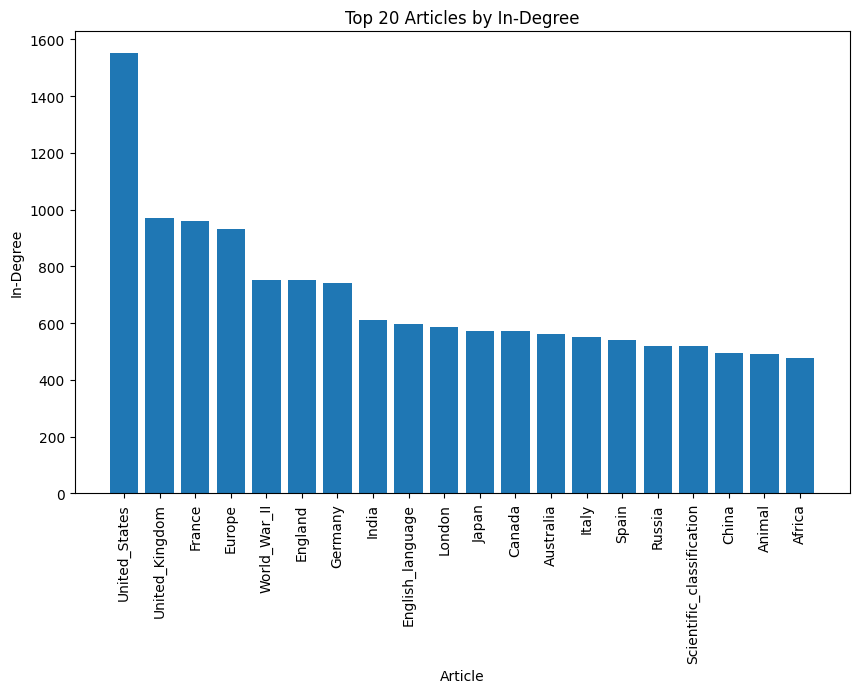

In [132]:
in_degrees = pd.DataFrame(graph_data["graph"].in_degree, columns=["article", "inDegree"])
in_degrees_sorted = in_degrees.sort_values("inDegree", ascending=False).head(n=20)

plt.figure(figsize=(10, 6))
plt.bar(in_degrees_sorted["article"], in_degrees_sorted["inDegree"])
plt.xlabel("Article")
plt.ylabel("In-Degree")
plt.title("Top 20 Articles by In-Degree")
plt.xticks(rotation=90);

Now we will enumerate the articles with in-degree 0. There are no hyperlink pointing towards these articles and they can never be reached from another article. Those articles are also called orphan articles.

In [133]:
in_degrees.query("inDegree == 0")

article  inDegree
0                                Áedán_mac_Gabráin         0
4                            Óengus_I_of_the_Picts         0
5                           €2_commemorative_coins         0
34    2005_Hertfordshire_Oil_Storage_Terminal_fire         0
36                 2005_Lake_Tanganyika_earthquake         0
...                                            ...       ...
4566                                  Yellowhammer         0
4575                                Yotsuya_Kaidan         0
4576                          You're_Still_the_One         0
4580                                  Yungay,_Peru         0
4588                                    Zara_Yaqob         0

[465 rows x 2 columns]

As we can see, there are 465 unreachable articles.

Now let us analyze the out degrees of the nodes. The out-degree of an article is the number of hyperlinks in that article.

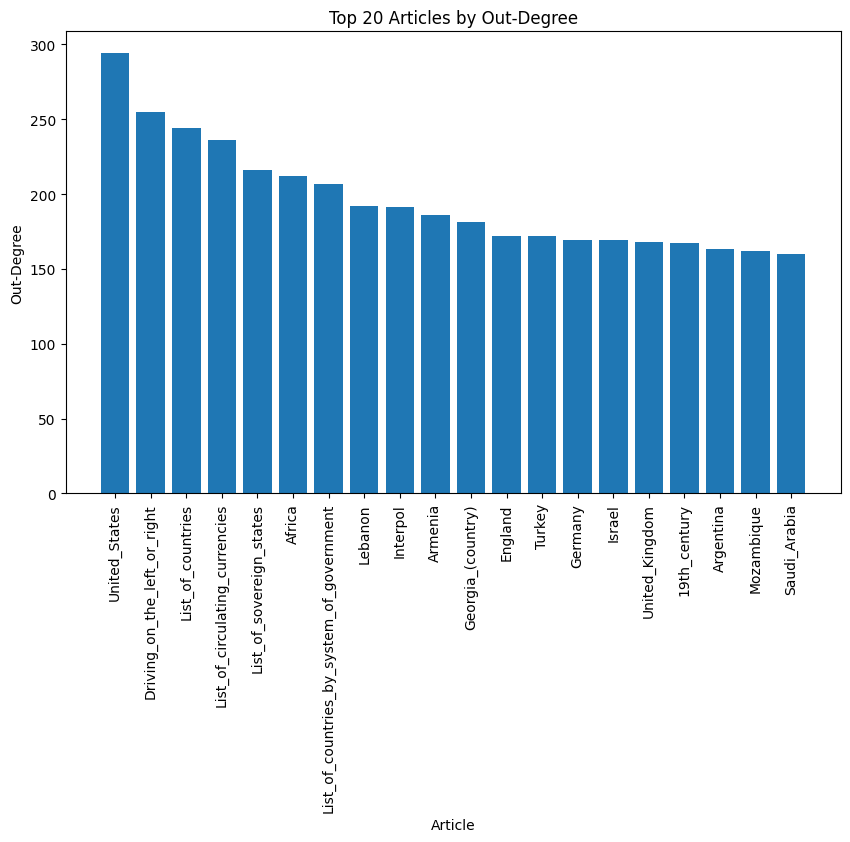

In [134]:
out_degrees = pd.DataFrame(graph_data["graph"].out_degree, columns=["article", "outDegree"])
out_degrees_sorted = out_degrees.sort_values("outDegree", ascending=False).head(n=20)

plt.figure(figsize=(10, 6))
plt.bar(out_degrees_sorted["article"], out_degrees_sorted["outDegree"])
plt.xlabel("Article")
plt.ylabel("Out-Degree")
plt.title("Top 20 Articles by Out-Degree")
plt.xticks(rotation=90);

In [135]:
out_degrees.query("outDegree == 0")

article  outDegree
441                                              Badugi          0
970                              Color_Graphics_Adapter          0
1210                                        Directdebit          0
1231                                           Donation          0
1237                                       Douglas_DC-4          0
1257                        Duchenne_muscular_dystrophy          0
2351                             Klinefelter's_syndrome          0
2530                                    Local_community          0
2543                              Lone_Wolf_(gamebooks)          0
3108                                       Osteomalacia          0
3352                                   Private_Peaceful          0
3645                                      Schatzki_ring          0
3928                                        Suikinkutsu          0
4289                              Underground_(stories)          0
4333                                         Vacutainer          0
4480  Wikipedia_Text_of_the_GNU_Free_Documentation_L...          0
4545                                        Wowpurchase          0

There are no node with out-degree 0. Every article has at least one hyperlink in it.

#### Hub-detection
We analyze the main hubs of the wikipedia network. A hub is a Wikipedia article that serves as a central node, linking to many other articles. 

We use the networkx hits function to detect the hubs.

In [139]:
graph_data["top_200_hubs"][:10]

[('United_States', 0.03200700973556944),
 ('Europe', 0.014288514610421112),
 ('United_Kingdom', 0.013541183870019558),
 ('England', 0.011879911089967287),
 ('Africa', 0.009278435436513601),
 ('Earth', 0.007903973698874068),
 ('World_War_II', 0.007684152102499427),
 ('North_America', 0.0059824357619878005),
 ('Germany', 0.005739168103755113),
 ('France', 0.005580619685426555)]

#### Community Detection

It can be interesting to explore how articles are connected to each other. Community analysis is a powerful tool for uncovering hidden structures in the Wikipedia graph, revealing what group of articles form communities, i.e. group of nodes that are densely connected internally. For that, we use the Leiden algorithm, a community-detection algorithm that works well for huge directed graph.

The detected communities can also help us further analyze players' behaviors by studying how they navigate across communities.

In [141]:
import leidenalg
import igraph as ig

communities = leidenalg.find_partition(
	ig.Graph.from_networkx(graph_data["graph"]), leidenalg.RBConfigurationVertexPartition, n_iterations=20, seed=5
)
node_names = {i: node for i, node in enumerate(graph_data["graph"].nodes())}
for i, community in enumerate(communities):
	if len(community) > 5:
		print(f"Community {i}, {len(community)}: {', '.join([node_names[node] for node in community[:5]])}...")

Community 0, 885: Åland, Édouard_Manet, €2_commemorative_coins, 10th_century, 11th_century...
Community 1, 820: ABO_blood_group_system, Aardvark, Abacá, Absinthe, Action_potential...
Community 2, 757: 1928_Okeechobee_Hurricane, 1973_oil_crisis, 1980_eruption_of_Mount_St._Helens, 1997_Pacific_hurricane_season, 2-6-0...
Community 3, 713: 15th_Marine_Expeditionary_Unit, 2004_Indian_Ocean_earthquake, 2005_Kashmir_earthquake, 2005_Lake_Tanganyika_earthquake, 2005_Sumatra_earthquake...
Community 4, 645: Áedán_mac_Gabráin, Éire, Óengus_I_of_the_Picts, 2005_Hertfordshire_Oil_Storage_Terminal_fire, A._E._J._Collins...
Community 5, 622: 16_Cygni, 16_Cygni_Bb, 1_Ceres, 3_Juno, 47_Ursae_Majoris...
Community 6, 124: ASCII, Abacus, Aggregator, Ajax_(programming), Algorithm...
Community 7, 24: Australian_Open, Björn_Borg, Boris_Becker, Brabham, Chris_Evert...


Below are the detected communities:
- Community 0 - **Europe 🇪🇺**. This community includes articles related to European countries, cities, landmarks, and notable figures.
- Community 1 - **Biology 🌱**. Comprising articles on animals, plants, and various natural sciences.
- Community 2 - **Americas 🌎**. This community covers a wide range of topics related to the american continent, including countries, historical events, presidents, and prominent figures.
- Community 3 - **Africa and Asia 🌍**. This community contains articles about countries, history, and cultures across Africa, Asia, and South America.
- Community 4 - **United Kingdom 🇬🇧**. Articles within this community delve into British history, culture, politics, notable figures, and cities.
- Community 5 - **Astronomy, chemistry, physics and maths ⚛️**. This community brings together articles on celestial bodies, the periodic table and physics and maths.
- Community 6 - **Computer Science 🤖**. Our favorite one, here we can find articles about programming languages, operating systems, ...
- Community 7 - **Tennis 🥎**. A small community of 24 articles, all about Tennis.

### Correlation between rank and remaining path length length

We want to determine whether players get better or worse as they progress within a single game, where better means finding the target in the least possible amount of clicks.
To explain our method, let's consider two hypothetical games:
- The first game is from `Bird` to `Sun`.
- The second game is from `Telephone` to `Sun`, but at some during the game, the player visits the article `Bird`.
In which of the two games will the player reach `Sun` from `Bird` in the least amount of clicks?
Now, for all the games where the target was `Sun` and where the player visited the article `Bird` at some point during the game, do the players reach `Sun` from `Bird` slower if their encounter with `Bird` happens later in the game?

To answer this question we will perform the following computation:

For every ordered pair of distinct articles $A$ and $B$, we consider the games where $B$ is the target,
and we study the correlation between the **rank**, that is, the moment in the game where $A$ is visited,
(ignoring those games where $A$ is not visited)
and the **remaining path length** (that is, the number of clicks the player takes to reach $B$ from $A$).

Although the correlation is not strong for most pairs, we see that there is a slight bias towards the positive side, meaning that the higher the rank, the longer the remaining path length.

In other words, players perform worse (maybe they get tired, or frustrated) the longer the game.

Further analysis could be made using different metrics, such as spearman's rank correlation, which works with non normal data
(it doesn't seem reasonable to assume that the distribution of the ranks is normal) and would allow us to formulate
the null hypothesis that there is relationship between rank and remaining path length.

## Navigation Strategies

In this section, we will explore four different navigation strategies employed by players in the Wikispeedia game. These strategies are:

1. **Hub-focused Strategy**: This strategy hypothesizes that players navigate through highly connected articles, or hubs, which serve as central nodes in the network.
2. **Semantic Search Strategy**: This strategy assumes that players are more likely to click on articles that are semantically closer to the target article.
3. **Backtracking Strategy**: This strategy assumes that players backtrack frequently.
4. **Clicking Quickly on Top Links Strategy**: This strategy supposes that players, tend to click on the first links that appear on the page.

We will analyze each strategy in detail to understand their effectiveness and how they influence the players' navigation paths.


## Hub-focused strategy

In this strategy, we hypothesize that players navigate through “hub” articles - highly connected articles that serve as navigation landmarks in the Wikspeedia network. To identify these hubs, we use PageRank, which ranks articles based on their centrality and importance in the network. Thus, using this strategy, players can access a broad set of connections and navigate closer to the target. We then analyze whether players tend to use these hub articles in their successful navigation paths. To see that there is a clear pattern of paths going through general articles, we analyze the behavior for an average path.

To quantify the extent to which players rely on hubs in their navigation paths, we define the **Hub Usage Ratio (HUR)** as follows:

$$
\text{Hub Usage Ratio (HUR)} = \frac{\text{Number of Hub Articles in the Path}}{\text{Total Number of Articles in the Path}}
$$

Where:
- **Hub Articles**: Articles in the top 200 by PageRank.
- **Path**: The sequence of articles visited by the player during navigation.

This metric allows us to evaluate the degree to which players utilize hubs in their navigation. For example:
- A **HUR of 1.0** indicates that the player's path consists entirely of hub articles.
- A **HUR of 0.0** indicates that no hub articles were used in the path.

In [149]:
from src.scripts.data_story.plots.hubs_distribution import create_pagerank_distribution_plot

create_pagerank_distribution_plot(graph_data)

The choice of the top 200 articles as hubs is justified by both theoretical and empirical observations. **PageRank scores in networks often follow a power-law distribution**, where a small fraction of nodes (articles, in this case) capture a disproportionately large share of the network's importance. This is clearly visible in the distribution plot, where the PageRank scores sharply decline after the top-ranked articles.

The top 200 articles (representing only 4.3% of all articles) account for 44.1% of the total PageRank score. This aligns with the **scale-free property** of networks, where a few highly connected and influential nodes dominate the network structure. These hubs serve as natural navigation location, providing efficient access to many other articles.

By selecting the top 200 articles, we balance between capturing the most influential hubs and maintaining a manageable set. Including too many articles would dilute the concept of "hub" and reduce the navigation strategy's precision.

Moreover, examining the top 5 hubs **—United States, Europe, United Kingdom, England, and Africa—** reveals that they are broad, general-knowledge topics that naturally act as checkpoints for navigation. Beyond these, the PageRank scores drop significantly (from 0.032 for United States to 0.0093 for Africa). This supports the 200-article cutoff as an optimal choice.

In [150]:
from src.scripts.data_story.plots.hubs_distribution import create_hub_usage_ratio_plot

create_hub_usage_ratio_plot(graph_data)

This plot shows that finished paths tend to have a higher mean Hub Usage Ratio (HUR) compared to unfinished paths, suggesting that using hubs is a key factor in successful navigation.

## Semantic search strategy

In this strategy, we assume that the player is more likely to click on articles that are semantically closer to the target article.

The key question is whether the semantic similarity between the current article and the target article increases as players progress along their path. If this similarity grows, it would suggest that the player is following the strategy of selecting more semantically related articles.

We will do the following steps to answer that question:
1. Compute the TF-IDF matrix to represent the documents as embeddings
2. Compute the cosine similarity between two embeddings to assess how similar two articles are.
3. To quantify whether semantic similarity increases over time, we will use Spearman's rank correlation. 

The Spearman's rank correlation evaluates how well the order of semantic similarity aligns with a strictly increasing sequence. The correlation score ranges from -1 to 1, with 1 indicating a perfect monotonic increase in similarity. 

We will refer to this score as the semantic_increase_score (SIS).

Let us compute the TF-IDF matrix to assess the similarity between the top 5 articles.

In [151]:
from src.scripts.data_story.plots.semantic_strategy import similarity_matrix_figure

similarity_matrix_figure()

In [152]:
from src.scripts.data_story.plots.semantic_strategy import semantic_path_example
from src.utils.strategies.semantic_strategy import semantic_increase_score

path = graph_data["paths_finished"]["path"].iloc[9876]
print(path)
fig = semantic_path_example(path)
fig.show()
print(f"SIS = {semantic_increase_score(path, path[-1])}")

['Cinema_of_the_United_States', '20th_century', 'Vitamin', 'Anemia', 'Sickle-cell_disease', 'Malaria', 'Yellow_fever', 'Virus', 'Common_cold']


SIS = 0.7380952380952381


In [157]:
from src.utils.strategies.semantic_strategy import semantic_increase_score

scores = {"paths_finished": [], "paths_unfinished": []}

for key, value in scores.items():
	print(f"Computing scores for {key}...")
	for i, row in graph_data[key].iterrows():
		if len(row['path']) <= 3:
			continue  # Skip paths with a low article count as they are not statistically significant
		try:
			score = semantic_increase_score(row["path"], row["target"])
			value.append(score)
   
		except KeyError:
			print(f"Warning: {row['target']} was not found in the list of documents")

Computing scores for paths_finished...
Computing scores for paths_unfinished...


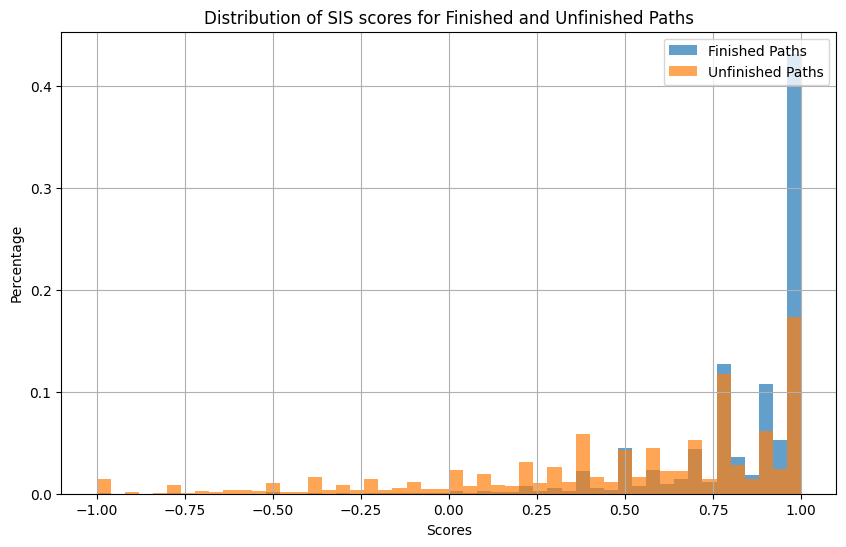

In [160]:
# Plot histogram for paths_finished and paths_unfinished on the same graph
plt.figure(figsize=(10, 6))
plt.hist(
	scores["paths_finished"],
	bins=50,
	weights=[1 / len(scores["paths_finished"])] * len(scores["paths_finished"]),
	alpha=0.7,
	label="Finished Paths",
)
plt.hist(
	scores["paths_unfinished"],
	bins=50,
	weights=[1 / len(scores["paths_unfinished"])] * len(scores["paths_unfinished"]),
	alpha=0.7,
	label="Unfinished Paths",
)
plt.xlabel("Scores")
plt.ylabel("Percentage")
plt.title("Distribution of SIS scores for Finished and Unfinished Paths")
plt.legend(loc="upper right")
plt.grid(True);

We can see in the above graph that finished paths tend to have a higher semantic increase score! This confirms our intuition that this strategy might be effective

## Backtrack strategy

The **Backtrack Strategy** aims to quantify exploratory behavior in navigation paths by analyzing how frequently players revisit previously visited nodes (backtracking). This behavior is measured using the **Backtrack Ratio (BR)**.

The Backtrack Ratio (BR) is defined as:

$$
BR = \frac{\text{Number of Backtrack Steps in Path}}{\text{Total Number of Steps in Path}}
$$

Where:
- **Backtrack Steps**: Moves represented by `<` in the path.
- **Total Steps**: All moves in the path, including backtracks.

In [161]:
from src.scripts.data_story.plots.backtrack_distribution import create_backtrack_analysis_plot

create_backtrack_analysis_plot(graph_data)

The distribution of backtrack ratios reveals insights into player navigation strategies:

1. **Limited Backtracking**:
   - Most paths have very low backtrack ratios, with a significant spike at \( BR = 0 \), indicating players largely prefer forward navigation.

2. **Finished vs. Unfinished Navigation**:
   - **Finished Paths** (67.4%): Tend to cluster around BR = 0 with a lower mean backtrack ratio (green dashed line), reflecting more efficient navigation.
   - **Unfinished Paths** (32.6%): Spread across higher BR values, with a higher mean backtrack ratio (red dashed line), indicating more exploratory behavior.

We see that on average, while the first and last articles are very specific, the middle articles are more general, confirming our hypothesis.
We also see that there is a decrease in generality towards the end when the player probably has a specific path in mind of how to join that article

## Link position strategy

Because the players are playing under time pressure, we assume they don't have time to look at the whole articles before making a selection. Therefore we state the hypothesis that players are clicking mostly on the first links that appear on the page.
The links are ordered lexicographically so we need to scan the html files to find the order of the links. Then we will normalize by the number of links on the page and look at the proportion of clicks that happen with the top 20% of links (so for example if there are 20 links on a given page, a click would count towards that quantity if it is on the first 4 links.)


In [173]:
from src.utils.strategies.link_strategy import get_click_positions

paths_finished = graph_data["paths_finished"]
paths_unfinished = graph_data["paths_unfinished"]

click_positions_fin = get_click_positions(paths_finished)
click_positions_unfin = get_click_positions(paths_unfinished)

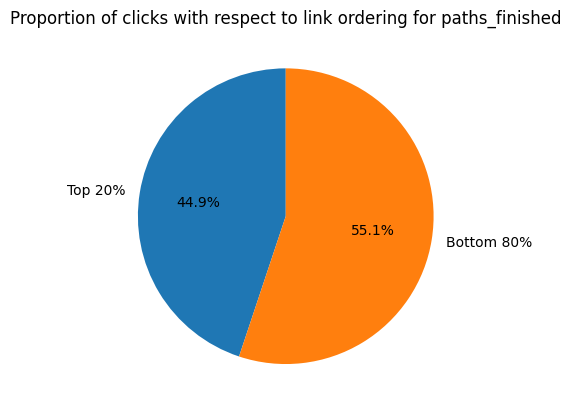

In [174]:
top_links = [pos for pos in click_positions_fin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_fin if pos > 0.2]


labels = ["Top 20%", "Bottom 80%"]
sizes = [len(top_links), len(otherlinks)]

# Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title("Proportion of clicks with respect to link ordering for paths_finished");

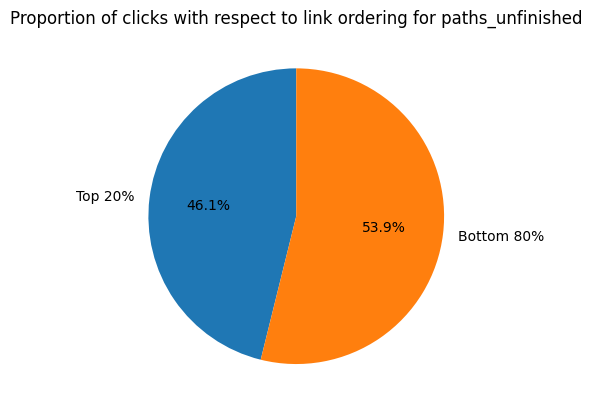

In [175]:
top_links = [pos for pos in click_positions_unfin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_unfin if pos > 0.2]

labels = ["Top 20%", "Bottom 80%"]
sizes = [len(top_links), len(otherlinks)]

# Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title("Proportion of clicks with respect to link ordering for paths_unfinished");

It appears that both paths that are finished and unfinished click mostly on links in the top of the page (45% instead of expected 20% if the players scanned the whole page and articles importance was disseminated at random.) So players employ this strategy that is not reflected in the shortest path matrix since it doesn't take into account the position of the links. Note that the slightly higher percentage of top clicks in paths_unfinished may mean that unsuccessful players are more naive, but this hypothesis needs to be tested more in detail because the difference is so small.


# Evaluating Strategies

### Simple evaluation metric

To measure the strengths of each strategies, we will start by comparing 2 simple evaluation metrics : success rate (among the paths using these strategies, how many are finished), and average completion time (the average time to finish the path).

In [177]:
from src.scripts.data_story.plots.link_strat_and_comparison import comparison_performance
from src.utils.strategies.comparison import build_comparison_df

finished, unfinished = build_comparison_df(graph_data)
barplot_success, barplot_time = comparison_performance(finished, unfinished)

In [178]:
barplot_success.show()

In [179]:
barplot_time.show()

The link strategy appears to have the shortest times while the semantic strategy has the best success rate.

## Better evaluation metric

The previous two evaluation metrics provide a straightforward way to analyze the performance of each strategy. However, they have notable limitations:

+ They do not account for confounding variables.
+ They classify strategies as either "used" or "not used," resulting in significant information loss.

To conduct a more rigorous evaluation, we will employ regression analysis, a powerful statistical tool.

Regression Analysis Plan
+ Model Selection: We will use a Mixed Linear Model instead of Ordinary Least Squares (OLS). This approach accounts for the confounding variable of game difficulty by grouping games by difficulty level.
+ Interaction Effects: To determine which interaction effects to include, we will use **backward selection**. This iterative process begins with a comprehensive model that includes all potential interaction terms. Then, terms are systematically removed based on statistical significance until only the most relevant terms remain.
+ Normalization: To enable meaningful comparison of coefficients, we will normalize the scores using z-score normalization.


In [183]:
from src.utils.strategies.comparison import perform_backward_selection, get_normalized_strategies_scores

paths_scores = get_normalized_strategies_scores()

print("Starting backward selection")
result = perform_backward_selection(paths_scores)
print("Backward selection finished\n")
print(result.summary())

Starting backward selection
Removing 'semantic_increase_score:top_links_ratio:backtrack_ratio' with p-value 0.0834576692514178
Removing 'top_links_ratio:backtrack_ratio' with p-value 0.04919355001890668
Removing 'top_links_ratio:hub_ratio:backtrack_ratio' with p-value 0.21531071162111037
Removing 'semantic_increase_score:top_links_ratio' with p-value 0.024017314347941084
Removing 'semantic_increase_score:top_links_ratio:hub_ratio:backtrack_ratio' with p-value 0.045410510469752335
Removing 'semantic_increase_score:top_links_ratio:hub_ratio' with p-value 0.0007512229812950902
Backward selection finished

                              Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           duration_in_seconds
No. Observations:             50138             Method:                       REML               
No. Groups:                   3323              Scale:                        11902.8300         
Min. group size:            

Let's analyze those results:
- $\beta_1 = -21.2$: The coefficient for the _semantic increase score (SIS)_ suggests that having a semantic increase score of 1 decreases the average game completion time by 21 seconds. That’s an impressive reduction!
- $\beta_2 = -8.2$: A high _top links click ratio_ also decreases completion time on average, but to a lesser extent compared to SIS
- $\beta_3 = 2.4$: A high _hub usage_ does not seem to improve the completion time
- $\beta_4 = 37.5$: _Backtracking_, on the other hand, has a significant negative impact, increasing the game time by 37.5 seconds on average for a backtracking ratio of 1. This number makes sense in some ways as spending too much time backtracking can be a waste of precious time.

Furthermore, all of the p-values are close 0 which is great news as this indicate that the results are statistically significant.

Another advantage of the Mixed Linear Model is that it allows us to extract the random effect term for each target. This term captures how difficult it is to reach a particular target, independent of the strategies used.

In [185]:
from src.scripts.data_story.plots.regression_analysis import plot_random_effects

plot_random_effects().show()

For instance, the target article with the highest random effect is _Cultural Diversity_, which has a random effect value of 210. This means that games ending at _Cultural Diversity_ take, on average, 210 seconds longer than the typical game duration. Upon closer examination, we observe that the article _Cultural Diversity_ has an in-degree of only one, and is only reachable from the article _Globalization_. This limited connectivity makes _Cultural Diversity_ particularly challenging to reach!

## Conclusion

This analysis of the Wikispeedia dataset has provided valuable insights into human navigation behaviors and the structural properties of the Wikispeedia network. By examining the network's characteristics, we gained a better understanding of the communities, hubs, and connections, while the study of navigation strategies highlighted the strengths and weaknesses of common approaches.

Key findings include:
- **Network Structure**: The Wikispeedia network exhibits a scale-free property with a few highly connected hubs. These hubs play a crucial role in navigation efficiency.
- **Navigation Strategies**: Players employ various strategies, including hub-focused, semantic search, backtracking, and link position strategies. Each strategy has its strengths and weaknesses, with the semantic search strategy showing the highest success rate and the link position strategy resulting in the shortest completion times. 

These findings enhance our understanding of how humans traverse information networks and offer a foundation for developing tools to predict navigation challenges and optimize user experience. Future work could explore additional strategies, refine existing metrics, and apply these insights to other information networks.